## Visualization

Visualization notebook for manuscript "Identification of two novel subsets of multi-marker-defined cancer-associated fibroblasts in non-small cell lung cancer with inverse associations to immune features, driver mutations, and survival" by Pellinen T. et al. (2022).

In [1]:
import glob
import imageio
from pathlib import Path
import numpy as np
import pandas as pd
import skimage
from skimage.transform import  resize
import skimage.morphology
from scipy.ndimage import distance_transform_edt as dist_trans
import scipy.stats as stats
from scipy.spatial import distance
from scipy.cluster import hierarchy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [2]:
rootpath = Path('BOMI2')
respath = Path('BOMI2_results')
outpath = Path('restmp')
spotpath = respath / 'BOMI2_15comb_ratios_threshold_region_panepi.csv'
patpath = respath / 'BOMI2_15comb_ratios_alldata.csv'
featpat = '_features.csv'
files = sorted(rootpath.glob('*'+featpat))
bomi = 'BOMI2'
# Channel file name mapping
if bomi=='BOMI2':
    channel_map = {'DAPI': '1B', 'PDGFRB': '1G', 'PDGFRA': '1O', 'FAP': '1R', 'SMA': '1V', 'PanEpiMask': '1B_PanEpiMask'}
else:
    channel_map = {'DAPI': 'DAPI_ORG', 'PDGFRB': 'AF488_ORG', 'PDGFRA': 'AF555_ORG', 'FAP': 'AF750_ORG', 'SMA': 'AF647_ORG', 'PanEpiMask': 'PanEpiMask'}

In [3]:
# General settings
panepimask_threshold = 0.25
dist = 100
channels = ['FAP', 'PDGFRA', 'PDGFRB', 'SMA']
# Set positivity threshold mean + x * std
thrmult = {'FAP': 1.0, 'PDGFRA': 1.0, 'PDGFRB': 1.0, 'SMA': 1.0, 'PanEpiMask': 0.0}
if bomi=='BOMI1':
    thrmult['PDGFRB'] = 2.0
caf_colors = [(0.9161184715926312, 0.587423760636183, 0.6402637703546576, 1),
 (0.8973766346534284, 0.581331119552612, 0.44148487925600133, 1),
 (0.7782374663890923, 0.5986613203716192, 0.29484958361511526, 1),
 (0.6719680352244916, 0.6192179417975445, 0.2788916330720411, 1),
 (0.5682750757836192, 0.6439174244465715, 0.2742028926629523, 1),
 (0.3762222606824923, 0.6834863779636997, 0.2789816498588522, 1),
 (0.28707643832653706, 0.6827184641186778, 0.5120890998875058, 1),
 (0.2919262167656853, 0.6747226468870757, 0.609182073124718, 1),
 (0.2973698332147099, 0.6691026915272558, 0.6777359581790809, 1),
 (0.31566519462741405, 0.6734654418170267, 0.762927200470503, 1),
 (0.42661352682565523, 0.6814005326938266, 0.8878562269048567, 1),
 (0.6793084340202084, 0.6711716015558182, 0.922564647141122, 1),
 (0.8082521797272784, 0.6083695194598239, 0.9133550448665896, 1),
 (0.905392959965527, 0.5456258765869806, 0.8605632696074983, 1),
 (0.9115949319567673, 0.570036518352846, 0.7498361257861439, 1)]

## Hierarchical clustering

In [4]:
df = pd.read_csv(spotpath)
df = df.dropna()

In [5]:
subgroup = ''
comb = [(a,b,c,d) for a in ['PDGFRA-','PDGFRA+'] for b in ['PDGFRB-','PDGFRB+'] for c in ['FAP-','FAP+'] for d in ['SMA-','SMA+']]
comb = [(a,b,c,d,'PanEpiMask-') for a,b,c,d in comb]
comb = comb[1:]
comb = [subgroup+''.join(x) for x in comb]

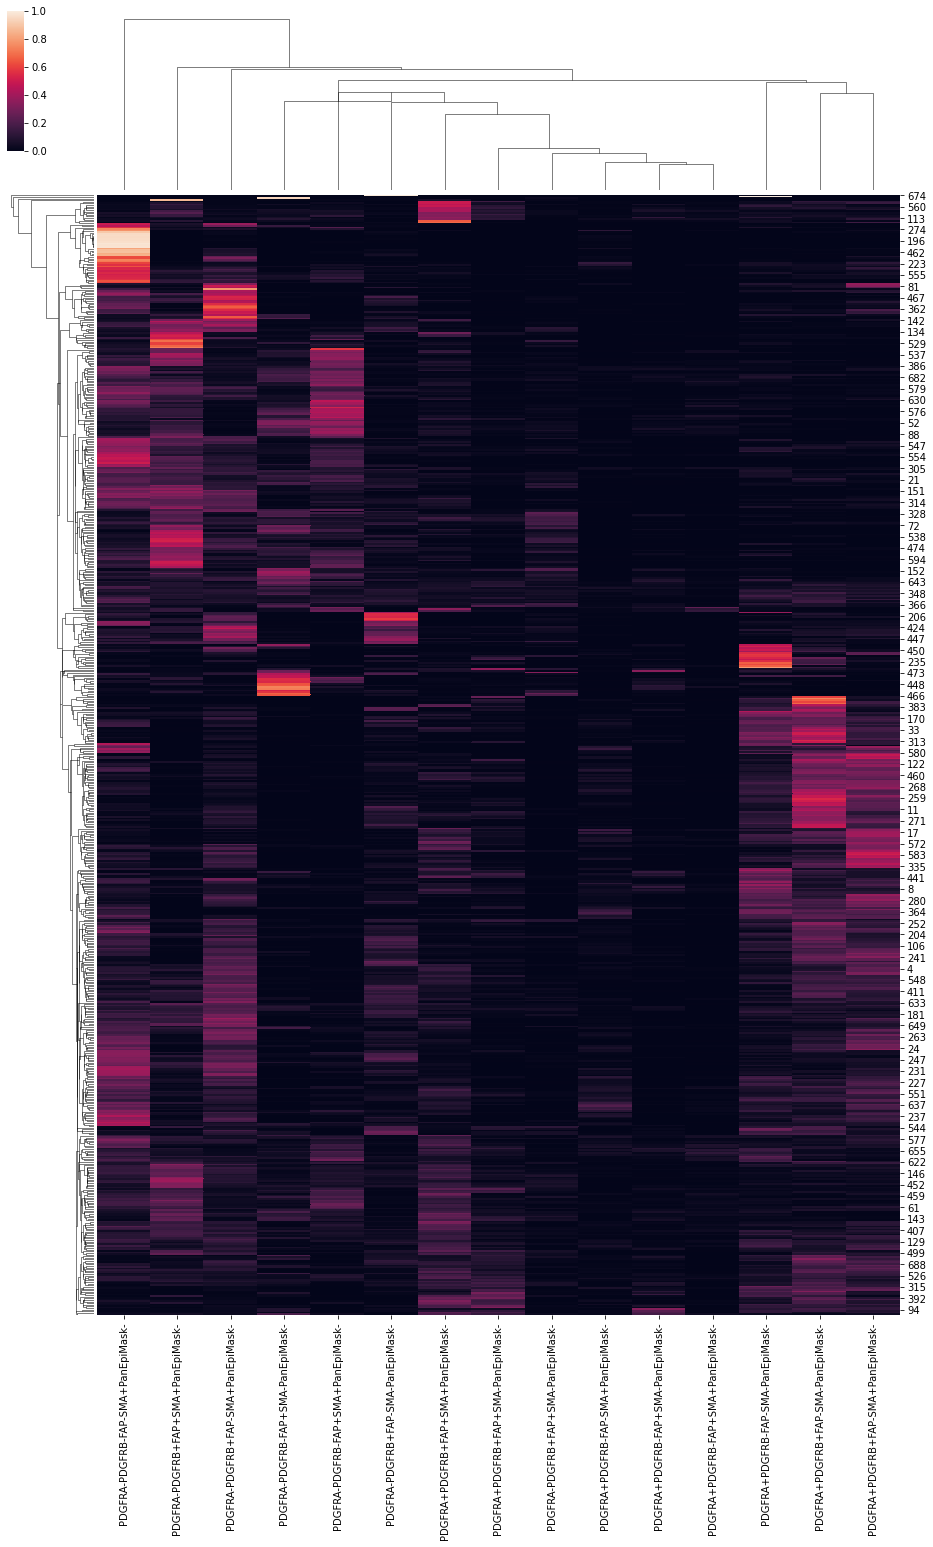

In [6]:
method = 'median'
values = df[comb].values
row_linkage = hierarchy.linkage(distance.pdist(values), method=method)
col_linkage = hierarchy.linkage(distance.pdist(values.T), method=method)
g = sns.clustermap(df[comb], method=method, figsize=(16,24))
plt.savefig(outpath / '{}_hier_clust_cafs_{}.pdf'.format(bomi,method), bbox_inches = "tight", dpi=300)

## Correlation

In [7]:
df = pd.read_csv(patpath)

In [8]:
subgroup = ''
comb = [(a,b,c,d) for a in ['PDGFRA-','PDGFRA+'] for b in ['PDGFRB-','PDGFRB+'] for c in ['FAP-','FAP+'] for d in ['SMA-','SMA+']]
comb = [(a,b,c,d,'PanEpiMask-') for a,b,c,d in comb]
comb = comb[1:]
comb = [subgroup+''.join(x) for x in comb]

In [9]:
df = df[comb].dropna()

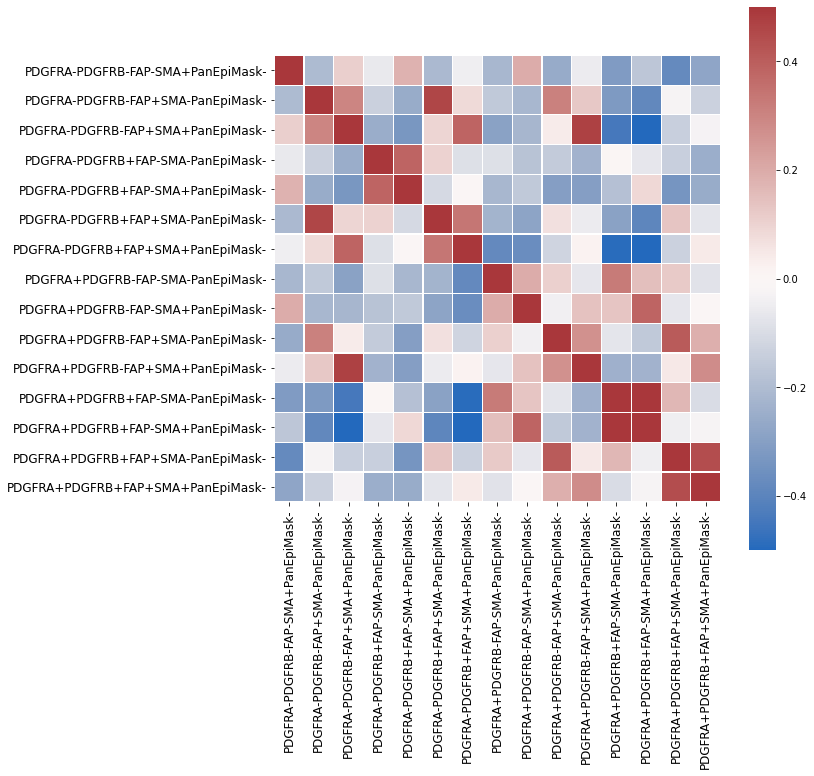

In [10]:
corr = df.corr()
vmin,vmax = -0.5,0.5
fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, vmin=vmin, vmax=vmax, square=True, linewidths=.1, cmap='vlag', ax=ax)
ax.tick_params(labelsize=12)
plt.savefig(outpath / '{}_corr_CAFs.pdf'.format(bomi), bbox_inches = "tight", dpi=300)

## Boxplots

### Fig 1a,b and Fig S1

In [11]:
df = pd.read_csv(patpath)
subset = '' # Either empty (all), 'juxta' or 'dista'

In [12]:
comb = [(a,b,c,d) for a in ['PDGFRA-','PDGFRA+'] for b in ['PDGFRB-','PDGFRB+'] for c in ['FAP-','FAP+'] for d in ['SMA-','SMA+']]
comb = comb[1:]
comb = [''.join(x)+'PanEpiMask-' for x in comb]

In [13]:
if subset == 'juxta':
    comb = ['Str100_'+x for x in comb]
elif subset == 'dista':
    comb = ['Str100+_'+x for x in comb]

In [14]:
df = df.dropna()

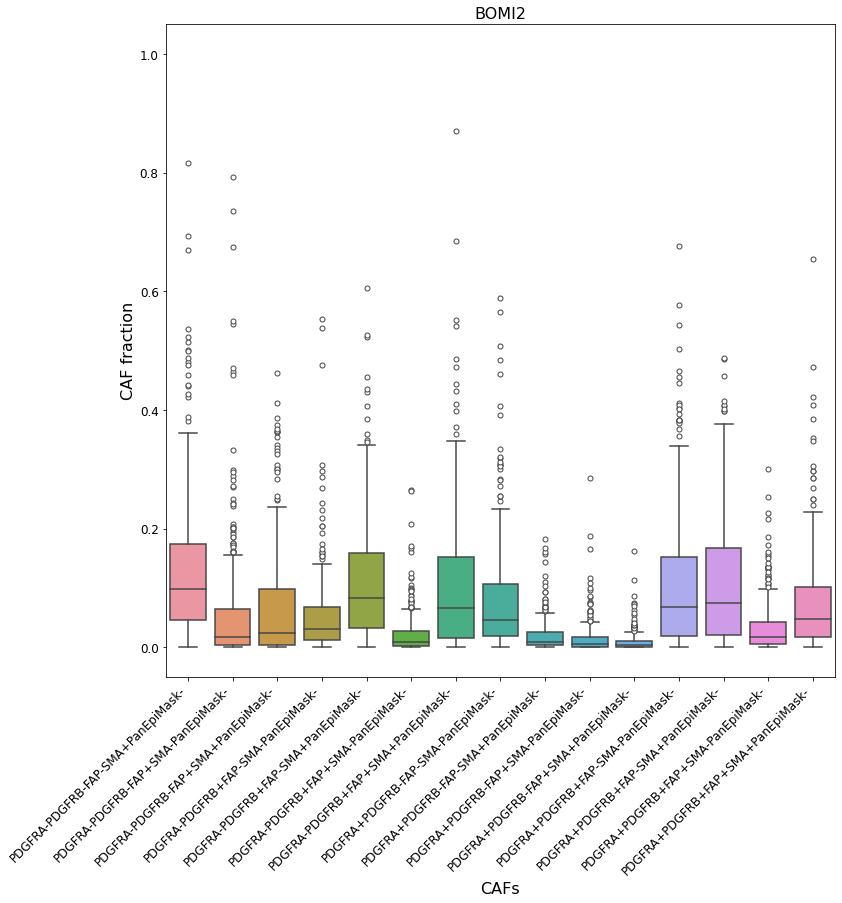

In [15]:
fig,ax = plt.subplots(1,1,figsize=(12,12))
vis = df[comb]
flierprops = dict(marker='o', markerfacecolor='white', markersize=5)
sns.boxplot(data=vis, flierprops=flierprops, linewidth=1.5, ax=ax)
ax.set(ylim=(-0.05,1.05))
if subset:
    ax.set_title("{} {}-epi".format(bomi,subset), fontsize=16)
else:
    ax.set_title("{}".format(bomi), fontsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_xlabel("CAFs", fontsize=16)
ax.set_ylabel("CAF fraction", fontsize=16)
ax.tick_params(labelsize=12)
if subset:
    plt.savefig(outpath / '{}_boxplot_cafs_fraction_{}.pdf'.format(bomi,subset), bbox_inches = "tight", dpi=300)
else:
    plt.savefig(outpath / '{}_boxplot_cafs_fraction.pdf'.format(bomi), bbox_inches = "tight", dpi=300)

### Fig 1c,d

In [16]:
df = pd.read_csv(patpath)
# Selected CAFs
scomb = [5,7,9,12]

In [17]:
juxta_cols = [x for x in df.columns.tolist() if 'Str100_' in x]
dista_cols = [x for x in df.columns.tolist() if 'Str100+_' in x]
df_dista = df[dista_cols].dropna()
df_juxta = df[juxta_cols].dropna()

In [18]:
tstat,pvalues = stats.ttest_ind(df_juxta, df_dista, equal_var=False)

In [19]:
comb = [(a,b,c,d) for a in ['PDGFRA-','PDGFRA+'] for b in ['PDGFRB-','PDGFRB+'] for c in ['FAP-','FAP+'] for d in ['SMA-','SMA+']]
comb = comb[1:]
comb = [''.join(x) for x in comb]
comb = [comb[i-1] for i in scomb]
pvalues = [pvalues[i-1] for i in scomb]
pstars = []
for val in pvalues:
    pstar = '-'
    if val < 0.05:
        pstar = '*'
    if val < 0.01:
        pstar = '**'
    if val < 0.001:
        pstar = '***'
    pstars.append(pstar)

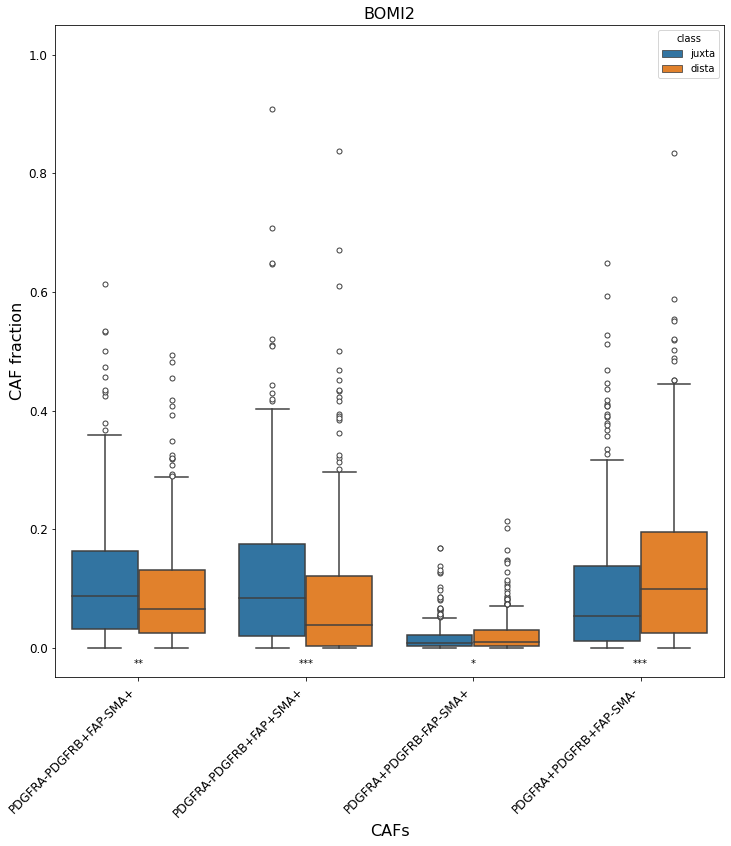

In [20]:
fig,ax = plt.subplots(1,1,figsize=(12,12))
dfj = df_juxta
dfd = df_dista

dfj.columns = [x.replace('PanEpiMask-','') for x in dfj.columns.tolist()]
dfj.columns = [x.replace('Str100_','') for x in dfj.columns.tolist()]
dfj = dfj[comb].stack().reset_index()
dfj.columns = ['id','caf','value']
dfj['class'] = 'juxta'
dfd.columns = [x.replace('PanEpiMask-','') for x in dfd.columns.tolist()]
dfd.columns = [x.replace('Str100+_','') for x in dfd.columns.tolist()]
dfd = dfd[comb].stack().reset_index()
dfd.columns = ['id','caf','value']
dfd['class'] = 'dista'
vis = pd.concat([dfj,dfd])
flierprops = dict(marker='o', markerfacecolor='white', markersize=5)
sns.boxplot(x='caf', y='value', hue='class', data=vis, flierprops=flierprops, ax=ax)
ax.set(ylim=(-0.05,1.05))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title("{}".format(bomi), fontsize=16)
ax.set_xlabel("CAFs", fontsize=16)
ax.set_ylabel("CAF fraction", fontsize=16)
ax.tick_params(labelsize=12)
for i,pstar in enumerate(pstars):
    plt.text(i, -0.035, pstar, ha='center', va='bottom', color='k')
plt.savefig(outpath / '{}_boxplot_selected_cafs_fraction.pdf'.format(bomi), bbox_inches = "tight", dpi=300)

## CAF plots

In [21]:
df = pd.read_csv(spotpath)

In [22]:
cols = df.columns.tolist()
cols = [x.replace('PanEpiMask-','') for x in cols]
df.columns = cols
# Add selected spots from two glasses
df04 = df[(df['glass'].str.contains('BOMI2_04'))&(df['spot'].isin([43,74,91,108]))]
df05 = df[(df['glass'].str.contains('BOMI2_05'))&(df['spot'].isin([42,46,47,76]))]
df = pd.concat([df04,df05], ignore_index=True)
df['glass_spot'] = df[['glass','spot']].apply(lambda x: "{}_{}".format(x[0].split('_')[1],x[1]), axis=1)

In [23]:
cafcols = []
for cafid in range(1,16):
    col = 'CAF{}'.format(cafid)
    cafcols.append(col)
    df[col] = df.iloc[:,2:2+cafid].sum(axis=1)

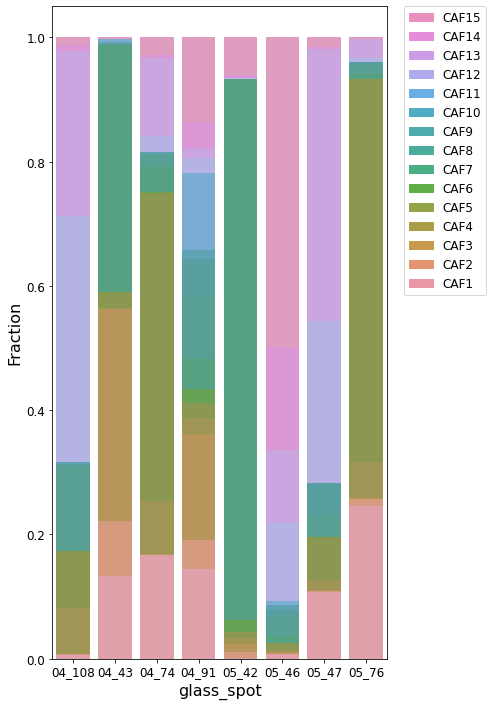

In [24]:
sns.set_context({"figure.figsize":(6,12)})
colors = caf_colors
patches = []
labels = []
for i in range(15,0,-1):
    ax = sns.barplot(y='CAF{:d}'.format(i), x='glass_spot', data=df, color=colors[i-1])
    ax.set_ylabel('Fraction', fontsize=16)
    ax.set_xlabel("glass_spot", fontsize=16)
    ax.tick_params(labelsize=12)
    patches.append(mpatches.Patch(color=colors[i-1]))
    labels.append('CAF{:d}'.format(i))
plt.legend(patches,labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=12)
plt.savefig(outpath / '{}_stacked_barplot_CAFs.pdf'.format(bomi), bbox_inches='tight', dpi=300)

## Visualize cell classes in images

In [25]:
def scale(img, mult=10):
    imedian = np.median(img)
    scaled = img.copy().astype(np.float32)
    scaled = scaled - imedian
    imean = scaled.mean()
    istd = scaled.std()
    scaled[scaled > imean+mult*istd] = imean+mult*istd
    scaled = (scaled - scaled.min()) * 255 / (scaled.max() - scaled.min())
    scaled = scaled.astype(np.uint8)
    return scaled

In [26]:
def calculate_thresholds(channels, panepimask_threshold):
    # Calculate thresholds as mean + x*std of all cells in panepi region for each channel
    aggstats = pd.DataFrame(data={'mean': [0.0]*len(channels), 'stdev': [0.0]*len(channels)}, index=channels)
    aggstats.index.name = 'channel'
    for ch in channels:
        aggstats.loc[ch,'mean'] = df.loc[df['PanEpiMask_mean']>=panepimask_threshold, '{}_mean'.format(ch)].mean()
        aggstats.loc[ch,'stdev'] = np.std(df.loc[df['PanEpiMask_mean']>=panepimask_threshold, '{}_mean'.format(ch)])

    aggstats.loc['PanEpiMask', 'mean'] = panepimask_threshold # Set PanEpiMask threshold
    aggstats.loc['PanEpiMask', 'stdev'] = 0.0 # Set PanEpiMask threshold
    
    return aggstats

In [27]:
def threshold_cells(thrdf, channels, aggstats, thrmult):
    thrcols = ['glass', 'spot']
    for ch in channels:
        thrcol = ch+'_'+'mean'
        thrcols.append(ch)
        thrdf[ch] = thrdf.loc[:,thrcol] > (aggstats.loc[ch,'mean'] + thrmult[ch]*aggstats.loc[ch,'stdev'])
    thrdf = thrdf[thrcols]
    
    return thrdf,thrcols

In [28]:
def crop_border(refimg, imgs):
    # Crop out empty border
    true_points = np.argwhere(refimg > 0)
    top_left = true_points.min(axis=0)
    bottom_right = true_points.max(axis=0)
    cropimgs = []
    for img in imgs:
        img = img[top_left[0]:bottom_right[0],top_left[1]:bottom_right[1]]
        cropimgs.append(img)
    
    return cropimgs

In [29]:
cafs = [(a,b,c,d) for a in ['PDGFRA-','PDGFRA+'] for b in ['PDGFRB-','PDGFRB+'] for c in ['FAP-','FAP+'] for d in ['SMA-','SMA+']]
cafs = [(a,b,c,d,'PanEpiMask-') for a,b,c,d in cafs]
# Drop quadruple negative
cafs = cafs[1:]

### Single CAF (Fig 2c,d)

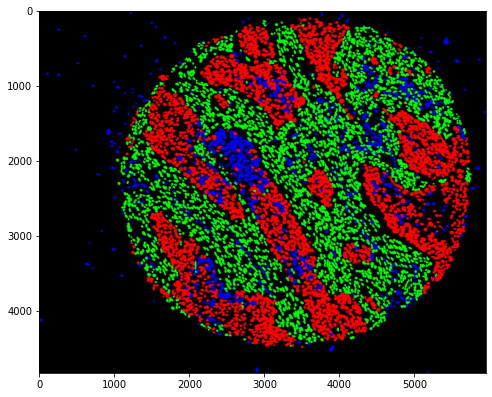

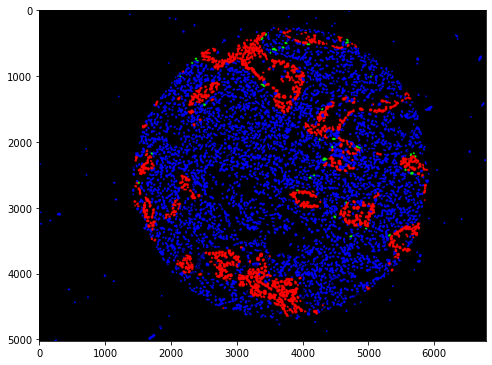

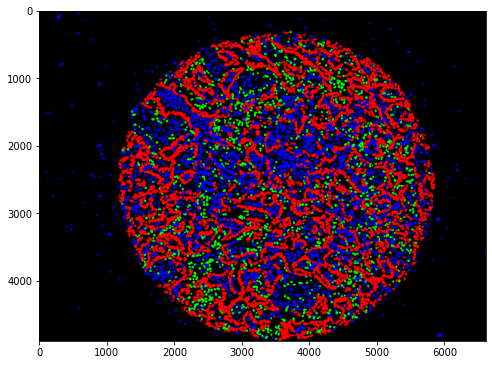

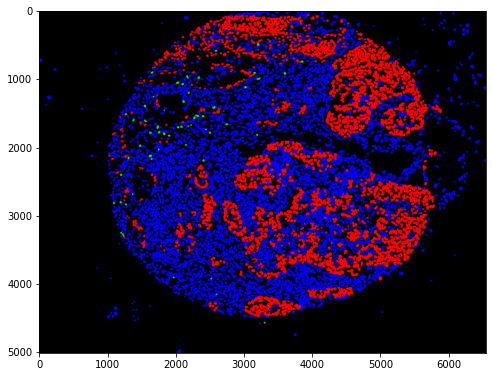

In [30]:
# Listing of visualized (glass,spot,caf)
vis = [(5,42,7), (5,46,7), (5,47,13), (4,91,13)]
channels = ['PDGFRA', 'PDGFRB', 'FAP', 'SMA', 'PanEpiMask']
for glassid,spot,cafid in vis:
    glass = files[glassid-1].name.split(featpat)[0]
    comb = cafs[cafid-1]
    df = pd.read_csv(files[glassid-1])    
    aggstats = calculate_thresholds(channels, panepimask_threshold)
    df = df[df['spot']==spot].reset_index(drop=True)
    thrdf,thrcols = threshold_cells(df.copy(), channels, aggstats, thrmult)

    nucpath = rootpath / '{}~A-Spots'.format(glass)
    nucpath = nucpath / 'vis_segm' / '{}~A-Spot{:06d}-{}.tif'.format(glass,spot,channel_map['DAPI'][1:])
    nucimg = imageio.imread(nucpath)
    panepipath = rootpath / '{}~A-Spots'.format(glass)
    panepipath = panepipath / '{}~A-Spot{:06d}-{}_PanEpiMask.tif'.format(glass,spot,channel_map['DAPI'][1:])
    panepiimg = imageio.imread(panepipath) * 255

    # Select bgchannel
    chimg = nucimg
    nucimg,panepiimg,chimg = crop_border(chimg, [nucimg,panepiimg,chimg])
    outshape = [x//2 for x in nucimg.shape]
    cafimg = skimage.color.gray2rgb(scale(chimg.copy())).astype(np.float32) / 255.0
    
    tumorcells = thrdf[thrdf['PanEpiMask']].index.values + 1
    comb_pos = np.logical_and.reduce([(thrdf[pos[:-1]]==True if pos[-1]=='+' else thrdf[pos[:-1]]==False) for pos in comb])
    comb_str = ''.join(comb)
    thrdf[comb_str] = comb_pos
    poscells = thrdf[thrdf[comb_str]].index.values + 1
    negcells = thrdf[~thrdf[comb_str]].index.values + 1
    posimg = np.zeros(nucimg.shape, dtype=np.uint8)
    posimg[np.isin(nucimg,poscells)] = 255
    negimg = np.zeros(nucimg.shape, dtype=np.uint8)
    negimg[np.isin(nucimg,negcells)] = 255
    cafimg[posimg==255,:] = [0,1,0]
    cafimg[negimg==255,:] = [0,0,1]
    cafimg[np.isin(nucimg,tumorcells),0] = 1
    cafimg[np.isin(nucimg,tumorcells),1] = 0
    cafimg[np.isin(nucimg,tumorcells),2] = 0
    cafimg = cafimg * 255.0
    cafimg = cafimg.astype(np.uint8)
    
    imageio.imwrite(outpath / 'vis' / 'glass{:02d}_spot{:06d}_CAF{:d}.png'.format(glassid,spot,cafid), skimage.transform.resize(cafimg, outshape, order=1, preserve_range=True).astype(np.uint8))
    fig = plt.figure(figsize=(8,cafimg.shape[1]/cafimg.shape[0]*8))
    plt.imshow(cafimg)

### All CAFs

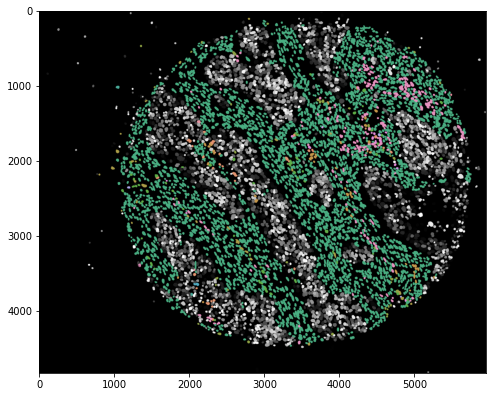

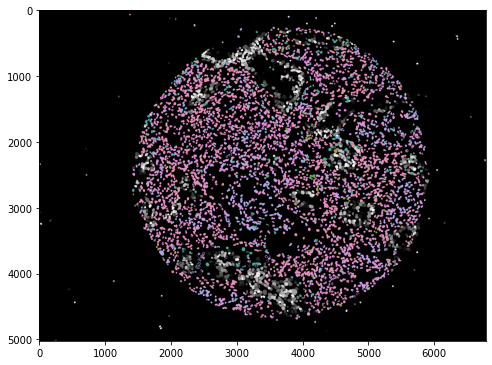

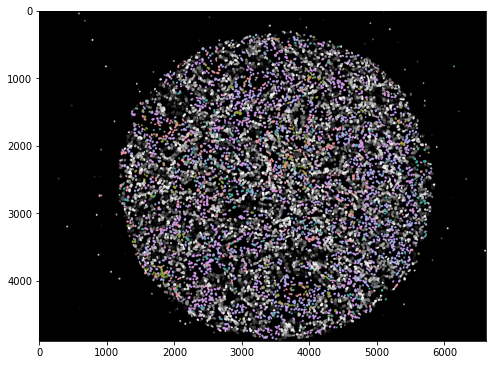

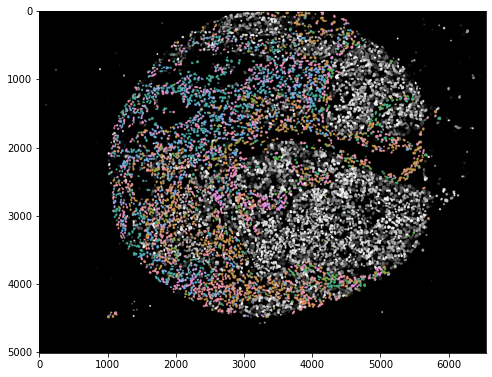

In [31]:
# Listing of visualized (glass,spot,caf)
vis = [(5,42,7), (5,46,7), (5,47,13), (4,91,13)]
channels = ['PDGFRA', 'PDGFRB', 'FAP', 'SMA', 'PanEpiMask']
for glassid,spot,cafid in vis:
    glass = files[glassid-1].name.split(featpat)[0]
    comb = cafs[cafid-1]
    df = pd.read_csv(files[glassid-1])
    aggstats = calculate_thresholds(channels, panepimask_threshold)
    df = df[df['spot']==spot].reset_index(drop=True)
    thrdf,thrcols = threshold_cells(df.copy(), channels, aggstats, thrmult)
    
    # Read images
    nucpath = rootpath / '{}~A-Spots'.format(glass)
    nucpath = nucpath / 'vis_segm' / '{}~A-Spot{:06d}-{}.tif'.format(glass,spot,channel_map['DAPI'][1:])
    nucimg = imageio.imread(nucpath)
    panepipath = rootpath / '{}~A-Spots'.format(glass)
    panepipath = panepipath / '{}~A-Spot{:06d}-{}_PanEpiMask.tif'.format(glass,spot,channel_map['DAPI'][1:])
    panepiimg = imageio.imread(panepipath) * 255

    # Select bgchannel
    chimg = nucimg
    nucimg,panepiimg,chimg = crop_border(chimg, [nucimg,panepiimg,chimg])
    outshape = [x//2 for x in nucimg.shape]
    cafimg = skimage.color.gray2rgb(scale(chimg.copy())).astype(np.float32) / 255.0

    tumorcells = thrdf[thrdf['PanEpiMask']].index.values + 1
    cafimg = skimage.color.gray2rgb(scale(chimg.copy())).astype(np.float32) / 255.0
    for cafid,comb in enumerate(cafs):
        comb_pos = np.logical_and.reduce([(thrdf[pos[:-1]]==True if pos[-1]=='+' else thrdf[pos[:-1]]==False) for pos in comb])
        comb_str = ''.join(comb)
        thrdf[comb_str] = comb_pos
        poscells = thrdf[thrdf[comb_str]].index.values + 1
        posimg = np.zeros(nucimg.shape, dtype=np.uint8)
        posimg[np.isin(nucimg,poscells)] = 255
        cafimg[posimg==255,:] = caf_colors[cafid][:3]

    cafimg = cafimg * 255.0
    cafimg = cafimg.astype(np.uint8)
    imageio.imwrite(outpath / 'vis' / 'glass{:02d}_spot{:06d}_CAFs.png'.format(glassid,spot), skimage.transform.resize(cafimg, outshape, order=1, preserve_range=True).astype(np.uint8))
    fig = plt.figure(figsize=(8,cafimg.shape[1]/cafimg.shape[0]*8))
    plt.imshow(cafimg)